<a href="https://colab.research.google.com/github/GuQiangJS/finance-tools-py/blob/master/jupyters/%E6%8C%87%E6%A0%87%E7%9B%B8%E5%85%B3%E6%80%A7%E6%B5%8B%E8%AF%95_%E5%8A%A8%E9%87%8F%E6%8C%87%E6%A0%87_RSI_%E7%9B%B8%E5%AF%B9%E5%BC%BA%E5%BC%B1%E6%8C%87%E6%95%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 初步结论

看上去直接用7日数据，取小于10或大于90日就有不错的效果

## 安装思源字体

这样显示好看点。呵呵！

In [0]:
import os
noto_font_path='/usr/share/fonts/NotoSansCJKsc-Medium.otf'
if not os.path.exists(noto_font_path):
    !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKsc-hinted.zip"
    !unzip "NotoSansCJKsc-hinted.zip"
    !mv NotoSansCJKsc-Medium.otf /usr/share/fonts/
from IPython.display import clear_output
clear_output(True)

--2020-03-21 06:01:11--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKsc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121063622 (115M) [application/zip]
Saving to: ‘NotoSansCJKsc-hinted.zip’

NotoSansCJKsc-hinte 100%[===================>] 115.46M  64.5MB/s    in 1.8s    

2020-03-21 06:01:13 (64.5 MB/s) - ‘NotoSansCJKsc-hinted.zip’ saved [121063622/121063622]

Archive:  NotoSansCJKsc-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKsc-Black.otf  
  inflating: NotoSansCJKsc-Bold.otf  
  inflating: NotoSansCJKsc-DemiLight.otf  
  inflating: NotoSansCJKsc-Light.otf  
  inflating: NotoSansCJKsc-Medium.otf  
  inflating: NotoSansCJKsc-Regular.otf  
  inflating: NotoSansCJKsc-Thi

## 安装第三方库。

[talib](https://www.fmz.com/bbs-topic/1234)，[finance-tools-py](https://github.com/GuQiangJS/finance-tools-py)

In [0]:
try:
    import talib
except ModuleNotFoundError:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    import talib
try:
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.backtest import BackTest
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import RSI
    from finance_tools_py.simulation.callbacks import Rolling_Future
    from finance_tools_py.backtest import AllInChecker
except ModuleNotFoundError:
    !pip install git+https://github.com/GuQiangJS/finance-tools-py.git -U
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.backtest import BackTest
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import RSI
    from finance_tools_py.simulation.callbacks import Rolling_Future
    from finance_tools_py.backtest import AllInChecker
clear_output(True)

## 其他相关引用

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# sns.set()
%matplotlib inline
# plt.rcParams['figure.figsize'] = (18, 6)
plt.style.use('ggplot')

fontprop = matplotlib.font_manager.FontProperties(fname=noto_font_path)
matplotlib.font_manager.fontManager.ttflist += matplotlib.font_manager.createFontList([noto_font_path])
plt.rcParams['font.family'] = fontprop.get_name()

plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  if sys.path[0] == '':


## 读取数据

1. 读取交易日期、开盘价、最高价、最低价、收盘价、成交量。所有数据均取**前复权**数据。

In [0]:
def read_data(symbol='600036'):
    data=pd.read_csv('https://raw.githubusercontent.com/GuQiangJS/temp/master/{}_daily.csv'.format(symbol),parse_dates=True,
                    usecols=['date','open_qfq','high_qfq','low_qfq','close_qfq','volume_qfq'])
    data['date']=pd.to_datetime(data['date'])
    data.rename(columns={'open_qfq':'open','high_qfq':'high','low_qfq':'low','close_qfq':'close','volume_qfq':'volume'},inplace=True)
    data['preclose']=data['close'].shift()
    data['nextclose']=data['close'].shift(-1)
    data['nextchange']=data['nextclose']-data['close']
    data['nextchange_sign']=np.sign(data['nextchange'])
    return data

## 指标应用原则



## 数据处理

~~计算两条线的上穿和下穿~~

In [0]:
class Cross_RSI(CallBack):
    def __init__(self,t1,t2):
        self.t1=t1
        self.t2=t2

    """双线相交法"""
    def on_preparing_data(self, data, **kwargs):
        data['上穿']=0
        data['下穿']=0
        l1='rsi_close_{}'.format(self.t1)
        l2='rsi_close_{}'.format(self.t2)
        data.loc[(data[l1]>data[l2]) & (data[l1].shift()<data[l2].shift()),'上穿']=1
        data.loc[(data[l1]<data[l2]) & (data[l1].shift()>data[l2].shift()),'下穿']=1

# class Rolling_Future_New(Rolling_Future):
#     def on_preparing_data(self, data, **kwargs):
#         super().on_preparing_data(data, **kwargs)
#         data['未来{}日涨跌'.format(self.timeperiod)]=np.sign(data['rolling_{}_{}_mean'.format(self.col_name,self.timeperiod)]-data[self.col_name])
#         data.rename(columns={'rolling_close_{}_mean/close'.format(self.timeperiod):'未来 {} 日均价/当前'.format(self.timeperiod)},inplace=True)



## 简单绘图示例

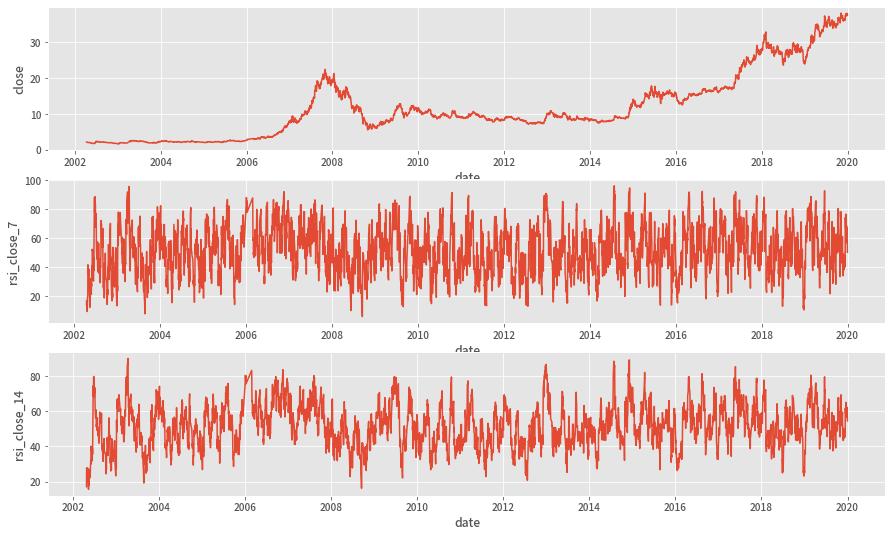

In [0]:
data=read_data('600036')
s=Simulation(data,'600036',callbacks=[RSI(7),
                    RSI(14)])
s.simulate()
fig,axes=plt.subplots(3,1,figsize=(15,9))
sns.lineplot(data=s.data,x='date',y='close',ax=axes[0])
sns.lineplot(data=s.data,x='date',y='rsi_close_7',ax=axes[1])
sns.lineplot(data=s.data,x='date',y='rsi_close_14',ax=axes[2])
plt.show()

### 7日RSI

In [0]:
cut_7=pd.cut(s.data['rsi_close_7'],bins=range(0,110,10))
print(pd.value_counts(cut_7,normalize=True,sort=False))

(0, 10]      0.001182
(10, 20]     0.023646
(20, 30]     0.077796
(30, 40]     0.160322
(40, 50]     0.212343
(50, 60]     0.208796
(60, 70]     0.166233
(70, 80]     0.100497
(80, 90]     0.041381
(90, 100]    0.007803
Name: rsi_close_7, dtype: float64


In [0]:
def plot1(symbol,timeperiod,max,min):
    data=read_data(symbol)
    s=Simulation(data,symbol,callbacks=[RSI(timeperiod)])
    s.simulate()
    plt.figure(figsize=(15,5))
    sns.lineplot(data=s.data,x='date',y='close')
    buy=s.data[s.data['rsi_close_{}'.format(timeperiod)]<=min]['date']
    plt.vlines(x=buy.values,ymin=s.data['close'].min(),ymax=s.data['close'].max(),colors='r')
    sell=s.data[s.data['rsi_close_{}'.format(timeperiod)]>=max]['date']
    plt.vlines(x=sell.values,ymin=s.data['close'].min(),ymax=s.data['close'].max(),colors='g')
    p=pd.value_counts(pd.cut(s.data['rsi_close_{}'.format(timeperiod)],bins=[0,min,max,100]),normalize=True,sort=False)
    title='{} RSI 线.({}<红色-超卖，>{}绿色-超买)'.format(symbol,min,max)
    title=title+'\n 超卖占比:{:.2%}'.format(p[0])
    title=title+'\n 超买占比:{:.2%}'.format(p[-1])
    plt.title(title)

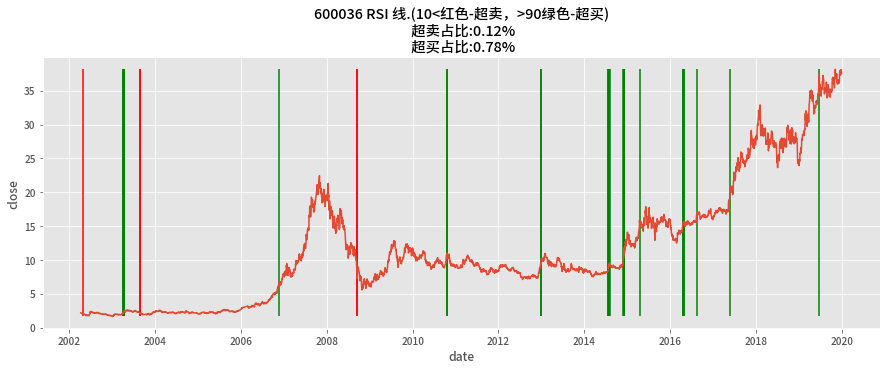

In [0]:
plot1('600036',7,90,10)

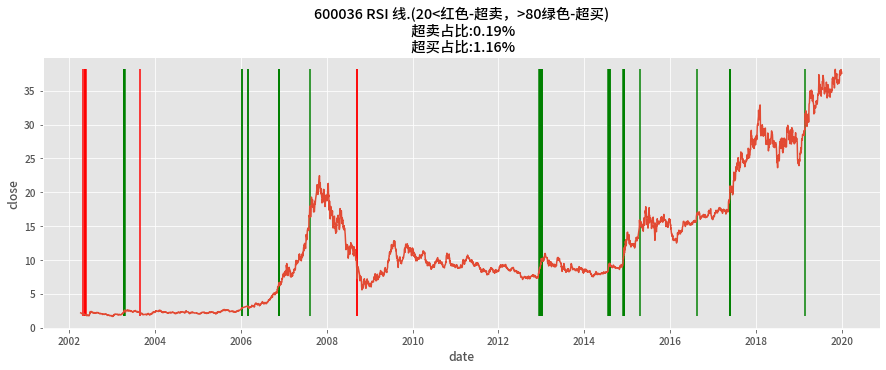

In [0]:
plot1('600036',14,80,20)

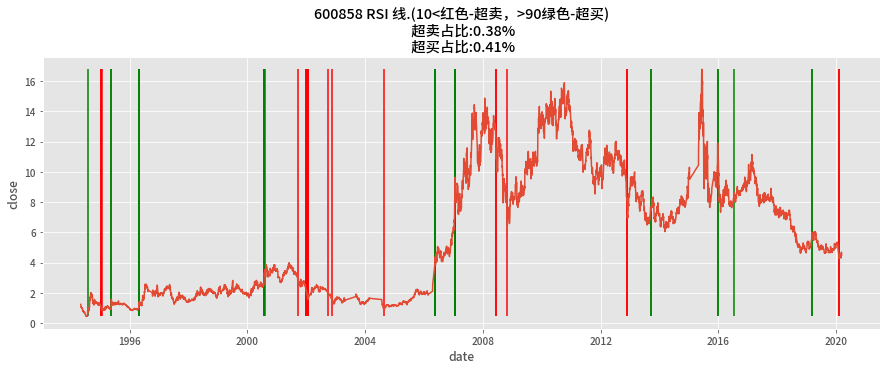

In [0]:
plot1('600858',7,90,10)

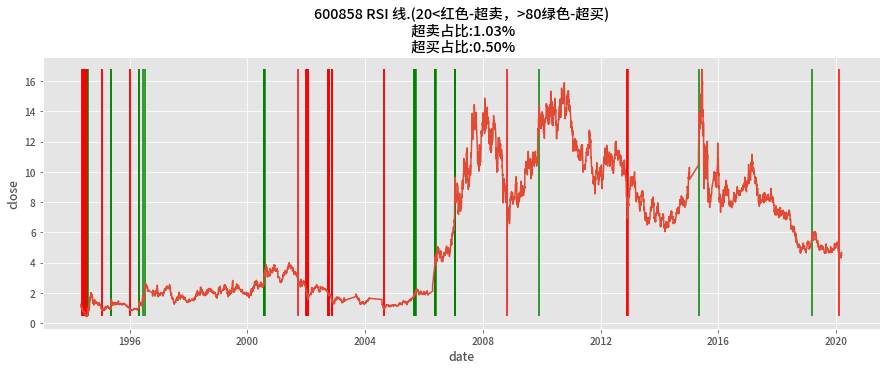

In [0]:
plot1('600858',14,80,20)

## 信号测试

交叉。一般有长、短期两条RSI，短期RSI大于长期RSI为多头市场，反之为空头市场。短期RSI在20以下超卖区内，由下往上交叉长期RSI时，为买进讯号。短期RSI在80以上超买区内，由上往下交叉长期RSI时，为卖出讯号。

In [0]:
def plot2(symbol,t1,t2,max=80,min=20):
    data=read_data(symbol)
    s=Simulation(data,symbol,callbacks=[RSI(t1),RSI(t2),Cross_RSI(t1,t2)])
    s.simulate()
    plt.figure(figsize=(15,5))
    sns.lineplot(data=s.data,x='date',y='close')
    buy=s.data[(s.data['rsi_close_{}'.format(t1)]<=min) & (s.data['上穿']==1)]['date']
    plt.vlines(x=buy.values,ymin=s.data['close'].min(),ymax=s.data['close'].max(),colors='r')
    sell=s.data[(s.data['rsi_close_{}'.format(t1)]>=max) & (s.data['下穿']==1)]['date']
    plt.vlines(x=sell.values,ymin=s.data['close'].min(),ymax=s.data['close'].max(),colors='g')
    p=pd.value_counts(pd.cut(s.data['rsi_close_{}'.format(t1)],bins=[0,min,max,100]),normalize=True,sort=False)
    title='{} RSI 线.({}<红色-超卖，>{}绿色-超买)'.format(symbol,min,max)
    title=title+'\n 超卖占比:{:.2%}'.format(p[0])
    title=title+'\n 超买占比:{:.2%}'.format(p[-1])
    plt.title(title)

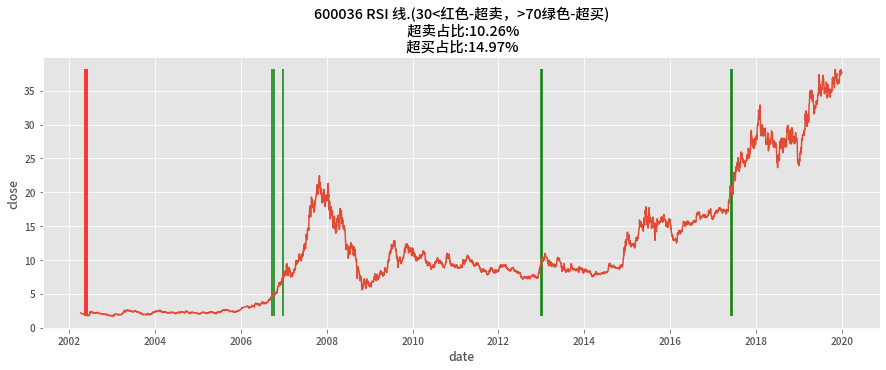

In [0]:
plot2('600036',7,14,max=70,min=30)

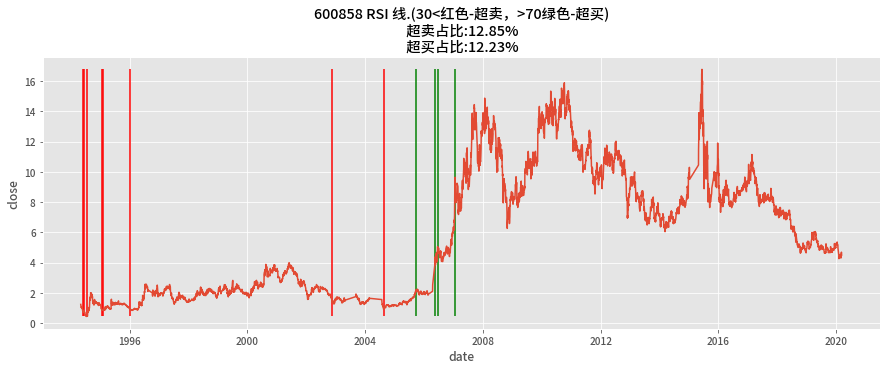

In [0]:
plot2('600858',7,14,max=70,min=30)

In [0]:
import plotly.graph_objects as go

def plot(data,x,y,buy=None,sell=None):
    plot_ly(data,x,y,buy,sell).show()
    plot_py(data,x,y,buy,sell)
    plt.show()

def plot_ly(data,x,y,buy=None,sell=None):
    fig = go.Figure()
    for y1 in y:
        fig.add_trace(go.Scatter(x=data[x], y=data[y1],mode='lines',name=y1))
    if buy:
        b=data[data[x].isin(buy)]
        fig.add_trace(go.Scatter(x=b[x], y=b['close'],mode='markers',marker=dict(color="red",size=6)))
    if sell:
        b=data[data[x].isin(sell)]
        fig.add_trace(go.Scatter(x=b[x], y=b['close'],mode='markers',marker=dict(color="green",size=6)))
    return fig

def plot_py(data,x,y,buy=None,sell=None):
    fig=plt.figure(figsize=(22,8))
    for y1 in y:
        sns.lineplot(data=data,x=x,y=y1)
    if buy:
        b=data[data[x].isin(buy)]
        plt.plot(b[x], b['close'],'r.')
    if sell:
        b=data[data[x].isin(sell)]
        plt.plot(b[x], b['close'],'gx')
    return fig

## 回测

In [0]:
import datetime

class C1(CallBack):
    def __init__(self,timeperiod,min=10,max=90):
        self.min=min
        self.max=max
        self.timeperiod=timeperiod

    def on_preparing_data(self, data, **kwargs):
        data['opt']=0
        data.loc[data['rsi_close_{}'.format(self.timeperiod)]<=self.min,'opt']=1
        data.loc[data['rsi_close_{}'.format(self.timeperiod)]>=self.max,'opt']=-1


class Checker(AllInChecker):
    
    def on_calc_buy_amount(self,
                           date: datetime.datetime.timestamp,
                           code: str,
                           price: float,
                           cash: float) -> float:
        # 每次最多买1/5
        return super().on_calc_buy_amount(date,code,price,cash*0.25)

    def on_check_sell(self,
                      date: datetime.datetime.timestamp,
                      code: str,
                      price: float,
                      cash: float,
                      hold_amount: float,
                      hold_price: float) -> bool:
        """当 `date` 及 `code` 包含在参数 :py:attr:`sell_dict` 中时返回 `True` 。否则返回 `False` 。"""
        if hold_amount>0 and hold_price*1.15>price:
            return False
        if code in self.sell_dict.keys() and date in self.sell_dict[code]:
            return True
        else:
            return False

def backtest(symbol,timeperiod,min=10,max=90,**kwargs):
    data=read_data(symbol)
    s=Simulation(data,symbol,callbacks=[RSI(timeperiod),C1(timeperiod)])
    s.simulate()
    s.data['code']=symbol
    buy=s.data[s.data['opt']==1]['date']
    sell=s.data[s.data['opt']==-1]['date']

    bt = BackTest(s.data, init_cash=10000, callbacks=[Checker(
        buy_dict={symbol: buy.dt.to_pydatetime()},
        sell_dict={symbol: sell.dt.to_pydatetime()})])
    bt.calc_trade_history(verbose=0)
    if kwargs.pop('print_report',True):
        print(bt.report(show_history=kwargs.pop('show_history',False)))
    if kwargs.pop('plot',True):
        plot(s.data,x='date',
            y=['close'],
            buy=list(buy.values),
            sell=list(sell.values)
            )
    return bt if bt else None

### 7日 x<10 | x>90


数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:8 (买入/卖出各算1次)
可用资金:23418.55
当前持仓:无
当前总资产:23418.55(现金+持股现价值)
资金变化率:234.19%
资产变化率:234.19%
总手续费:55.84
总印花税:43.83


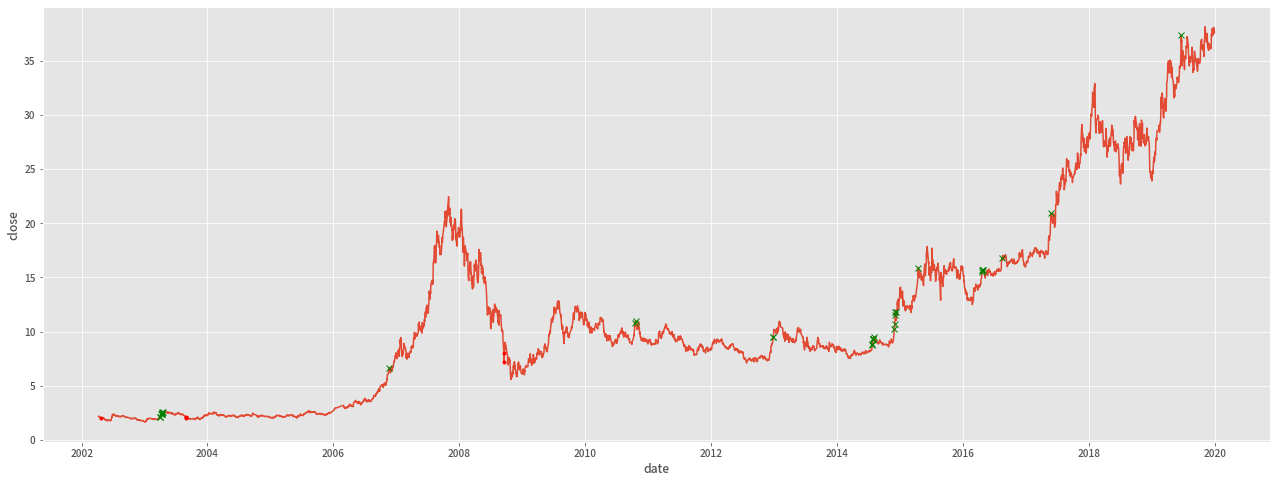

In [0]:
backtest('600036',7)


数据时间:1994-05-06 00:00:00~2020-03-09 00:00:00（可交易天数5860）
初始资金:10000.00
交易次数:25 (买入/卖出各算1次)
可用资金:18574.04
当前持仓:        buy_price  amount  price_cur
code                                
600858   4.378125  3200.0        4.5
当前总资产:32974.04(现金+持股现价值)
资金变化率:185.74%
资产变化率:329.74%
总手续费:175.59
总印花税:113.15


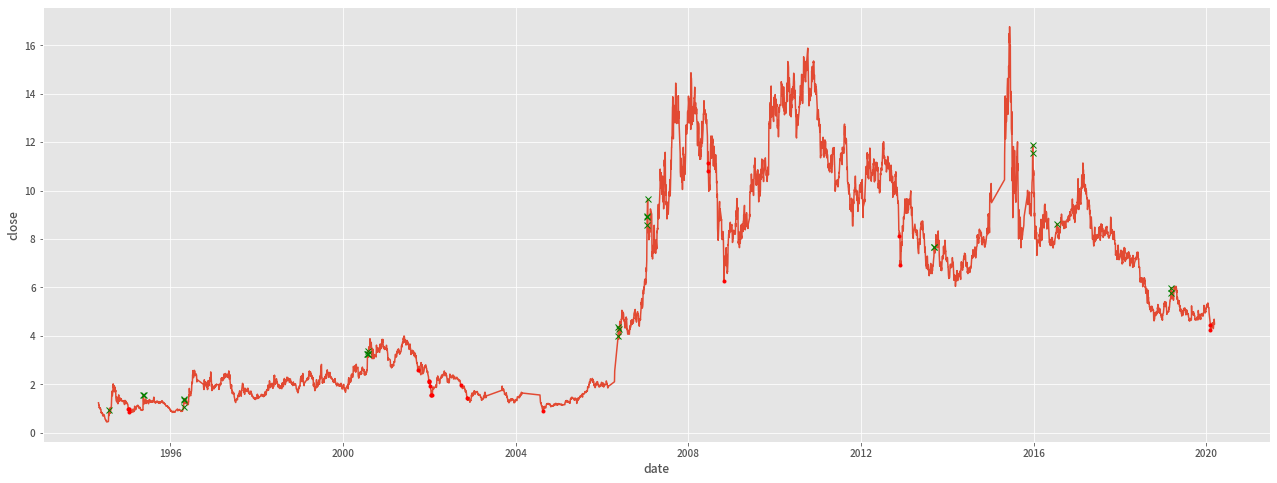

In [0]:
backtest('600858',7)

### 14日 x<20 | x>80


数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:0 (买入/卖出各算1次)
可用资金:10000.00
当前持仓:无
当前总资产:10000.00(现金+持股现价值)
资金变化率:100.00%
资产变化率:100.00%
总手续费:0.00
总印花税:0.00


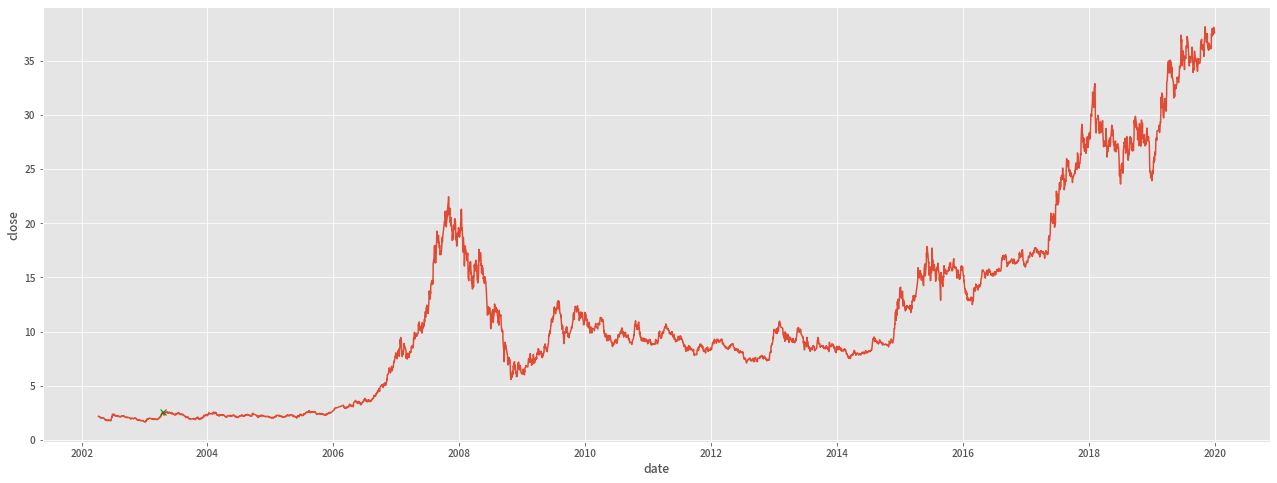

In [0]:
backtest('600036',14,min=20,max=80)


数据时间:1994-05-06 00:00:00~2020-03-09 00:00:00（可交易天数5860）
初始资金:10000.00
交易次数:0 (买入/卖出各算1次)
可用资金:10000.00
当前持仓:无
当前总资产:10000.00(现金+持股现价值)
资金变化率:100.00%
资产变化率:100.00%
总手续费:0.00
总印花税:0.00


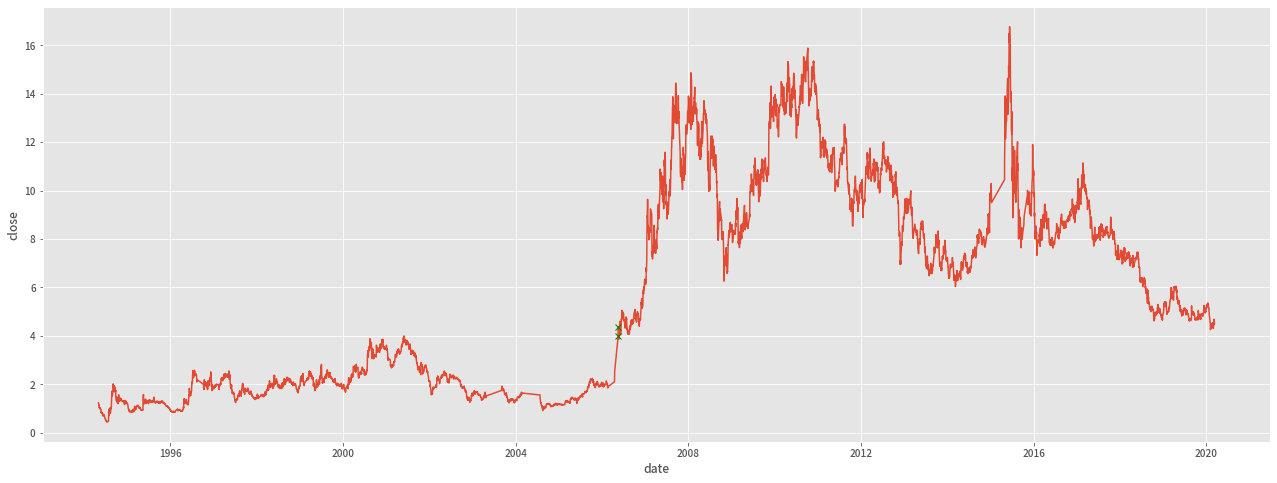

In [0]:
backtest('600858',14,min=20,max=80)